# Autoencoder for compressing the representation of 2d surface

This notebook contains a demo version of the code, which compresses images used as training samples for the CNN. The idea to use an autoencoder comes from an insight that for each shape on this images is parametrised with a small number of real values 

In [0]:
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The dataset for encoder is stored on my dropbox (share link in the cell below)

In [0]:
!wget https://www.dropbox.com/s/avusr38w43gqvby/dataset.tgz?dl=0
!mv dataset.tgz?dl\=0 dataset.tgz
!tar -xvf dataset.tgz

In [0]:
### Global hyperparameters for the CNN

DATA_PATH  = os.path.join(os.getcwd(), "dataset") # PATH TO THE DATASET
EPOCH_NUM  = 20  # Epochs
BATCH_SIZE = 64  # Batch size

In [0]:
import re

class GridDataset(Dataset):
    """
    Format for grid data is 'csv'
    Names of the files must contain numerals, due to the indexing issues
    File with the least numeral is considered to be a 'head' of the dataset
    
    """

    def __init__(self, root_dir, transform=None):
        """
        
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir    = os.path.join(os.getcwd(), root_dir)
        self.transform   = transform
        
        self.dir_content_data = [] #list with all seismogram filenames
        for file in os.listdir(self.root_dir):
            self.dir_content_data.append(
                (file, re.findall(r'(\d+)', file)[-1]))
        self.dir_content_data = [
            x[0] for x in list(sorted(self.dir_content_data, key= lambda x: x[1]))]
        
    def __len__(self):
        return len(self.dir_content_data)

    def __getitem__(self, idx):
        """
        Method allows to do 'online' loading from disk
        
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        grid_name = os.path.join(self.root_dir,
                                 self.dir_content_data[idx])
        data = np.genfromtxt(grid_name, delimiter=",").reshape([128, 128])

        if self.transform:
            data = self.transform(data)

        return data

In [0]:
transformer = transforms.Compose([  
    transforms.Lambda(lambda x: torch.from_numpy(x).view(1, x.shape[0], x.shape[1]))
])

train_dataset = GridDataset(
    os.path.join(DATA_PATH, 'train/'), transform=transformer
)
val_dataset = GridDataset(
    os.path.join(DATA_PATH, 'test/'), transform=transformer
)

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True)

n_train, n_val = len(train_dataset), len(val_dataset)

### Samples of surfaces with simple geometry

torch.Size([1, 128, 128])


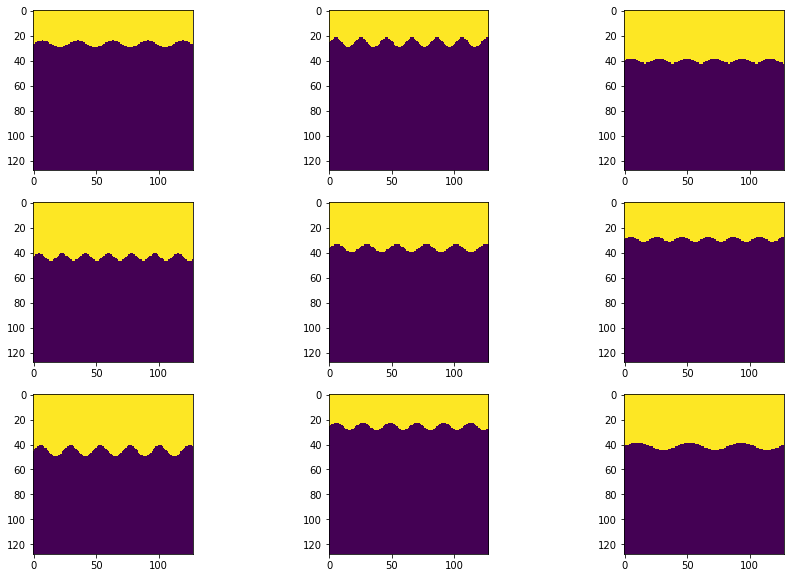

In [0]:
def plot_from_batch_generator(batch_gen):
    data_batch = next(iter(batch_gen))
    print(data_batch[0].shape)
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):
        axarr[i // grid_size[0], i % grid_size[0]].imshow(data_batch[i][0])

plot_from_batch_generator(train_batch_gen)

### Loss function for training is  binary cross entropy

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output


def loss(preds, labels):
    sm = torch.nn.Sigmoid()
    preds = sm(preds)
    return torch.sum((-1) * (
        labels * torch.log(preds + 1e-7) + (1 - labels) * torch.log(1. - preds + 1e-7)
    )) / preds.shape[0]


def train_model(
    model, train_batch_generator, val_batch_generator, opt, 
    ckpt_name=None, n_epochs=EPOCH_NUM):
    """
    Train a CNN model
    :params opt - optimizer
    :params cktp_name - name of the checkpoint file
    :params n_epochs - number of epochs
    
    """
    
    train_loss, val_loss = [], [] # arrays for loss history over the batch
    loss_history_train, loss_history_val = [], [] # arrays for loss history over the epoch
    
    model = model.to(device)
    
    # adjust the lr on the plateau
    lr_scheduler = ReduceLROnPlateau(opt, patience=5, factor=0.5, verbose=True) 
    
    top_val_loss_value = np.inf
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        
        model.train(True) # enable dropout / batch_norm training behavior
        for batch in tqdm(train_batch_generator, desc='Training'):
            
            batch = batch.to(device)         
            opt.zero_grad()
            preds_train = model.forward(batch)
            loss_train  = loss(preds_train, batch)
            loss_train.backward()
            opt.step()
            
            train_loss.append(loss_train.cpu().data.numpy())
        
        # Evaluation phase
        model.train(False) # disable dropout / use averages for batch_norm
        for batch in tqdm(val_batch_generator, desc='Validation'):
            
            batch = batch.to(device)
            preds_test = model.forward(batch)
            loss_test  = loss(preds_test, batch)
            val_loss.append(loss_test.cpu().data.numpy())

        
        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_loss_value  = np.mean(val_loss[-n_val // BATCH_SIZE :])
        
        lr_scheduler.step(val_loss_value)
        
        loss_history_train.append(train_loss_value)
        loss_history_val.append(val_loss_value)
        
        if val_loss_value < top_val_loss_value and ckpt_name is not None:
            top_val_loss_value = val_loss_value
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.plot(loss_history_train, label='train')
        plt.plot(loss_history_val,     label='val')
        plt.grid(True)
        plt.legend()
        if epoch: plt.show()
            
        # print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, n_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss_value))
        print("  validation loss (in iteration): \t\t\t{:.6f} ".format(val_loss_value))
        
        
        
    return model, opt

### The architecture for encoder is heavily based on UNet, but simplified due to the peculiarity of the problem

See https://arxiv.org/pdf/1505.04597.pdf for the original article

In [0]:
class UNet2(torch.nn.Module):

    def __init__(self, 
                 activation='ReLU',
                 pooling='max'):
      
        super(UNet2, self).__init__()

        if activation == 'ReLU':
            activation_function  = nn.ReLU()
        elif activation == 'LeakyReLU':
            activation_function  = nn.LeakyReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'max':
            pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        # ----------------- Encoder -------------------

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            activation_function,
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            activation_function,
            pooling_layer
        )
               
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            pooling_layer,
            nn.Dropout2d(p=0.4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_function,
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_function,
            pooling_layer,
            nn.Dropout2d(p=0.4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )

        self.encoder = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4
        )
        
        # ---------------------------------------------
        # ----------------- Decoder -------------------

        self.conv5 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            activation_function
        )
    
        self.conv6 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.Dropout2d(p=0.4)
        )
        
        self.conv7 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            activation_function,
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            activation_function,
            nn.Dropout2d(p=0.4)
        )
        
        self.conv8 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            activation_function,
            nn.Conv2d(16, 1, kernel_size=3, padding=1)
        )

        self.decoder = nn.Sequential(
            self.conv5,
            self.conv6,
            self.conv7,
            self.conv8
        )

    def encode(self, x):
        h = self.encoder(x)
        return h

    def decode(self, h):
        x = self.decoder(h)
        return x
      
    def forward(self, x):        
        return self.decode(self.encode(x))

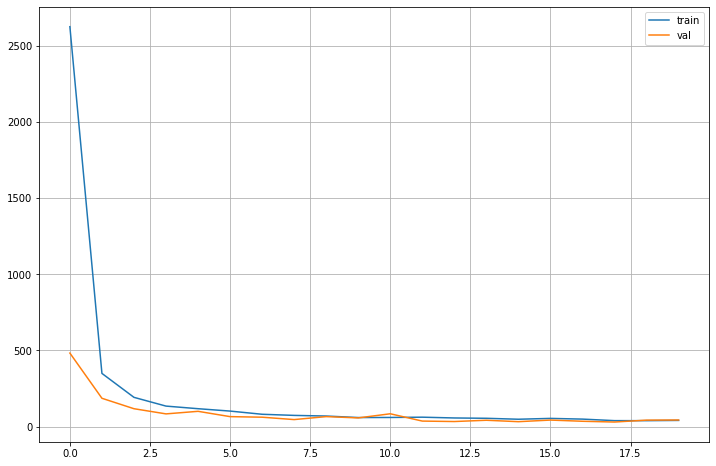

Epoch 20 of 20 took 350.360s
  training loss (in-iteration): 	40.468884
  validation loss (in iteration): 			43.283492 


In [0]:
unet = UNet2(activation='LeakyReLU').double()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)
best_model, _= train_model(
    unet, train_batch_gen, val_batch_gen, optimizer, 
    n_epochs = EPOCH_NUM, ckpt_name='unet.pth'
)

In [0]:
unet.train(False)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


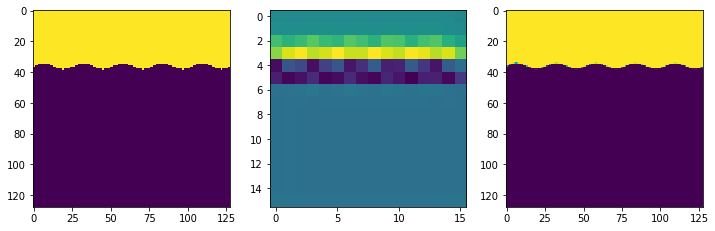

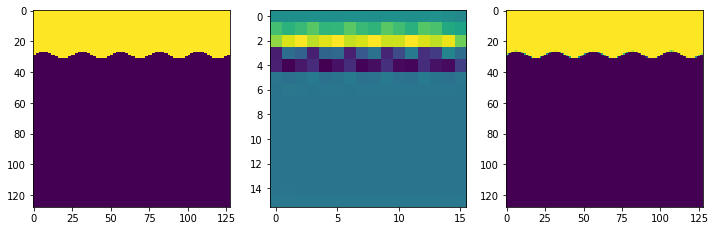

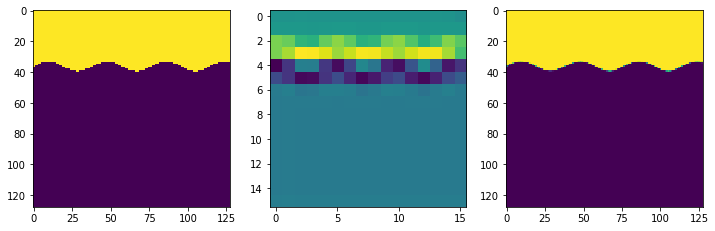

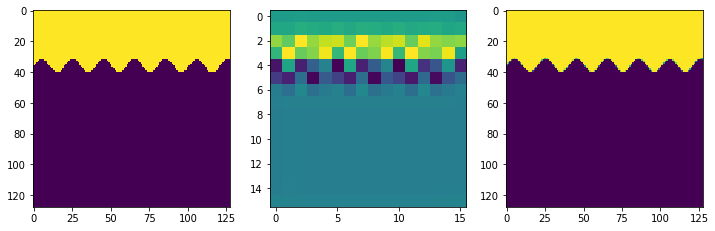

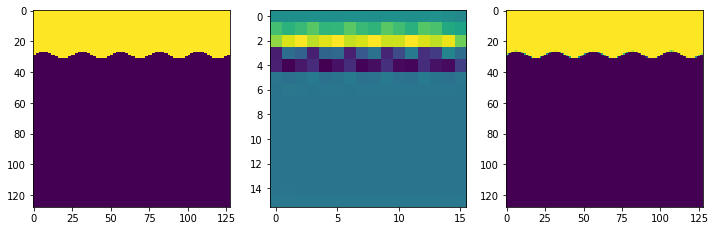

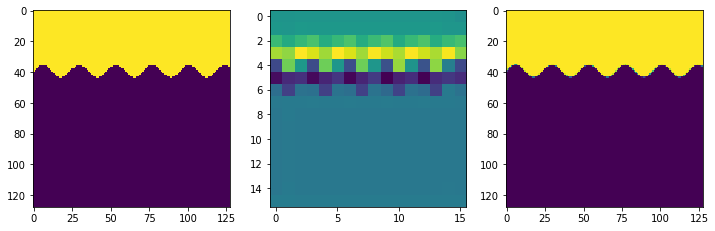

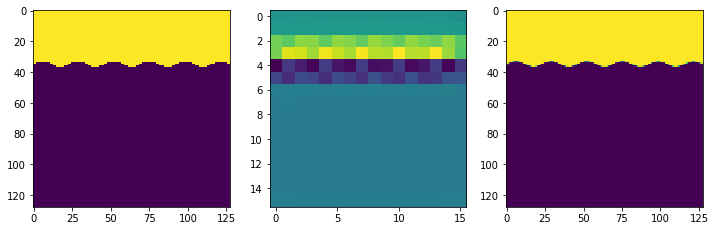

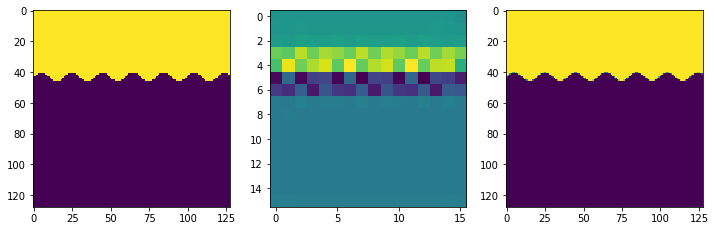

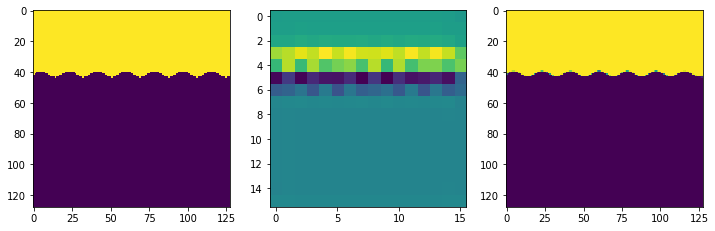

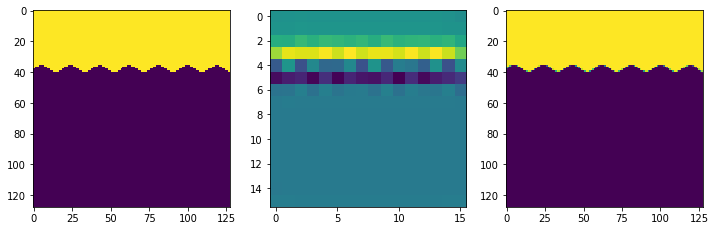

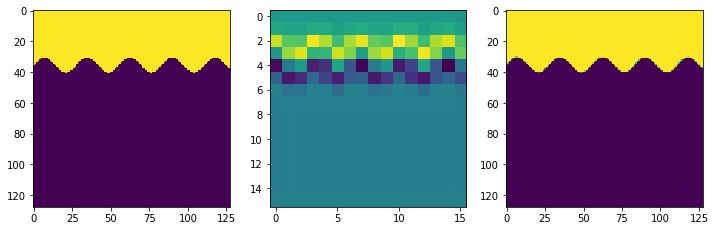

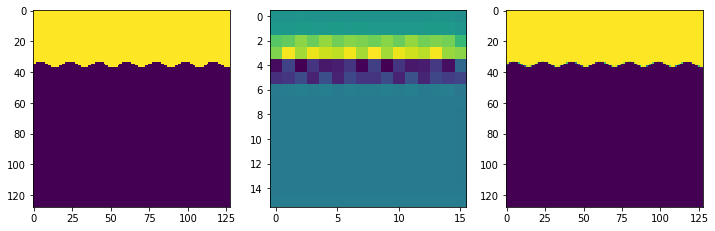

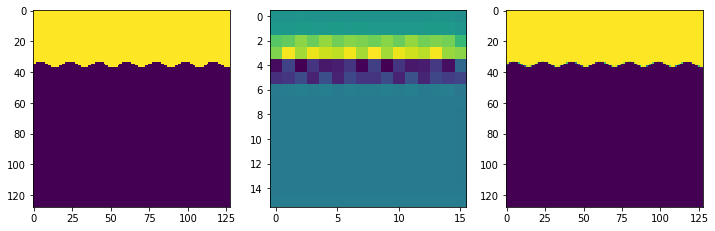

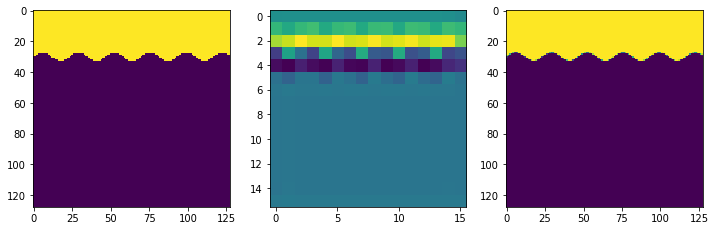

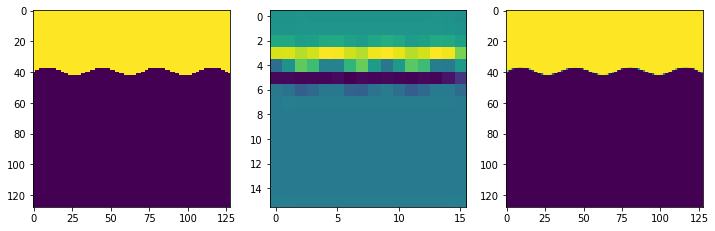

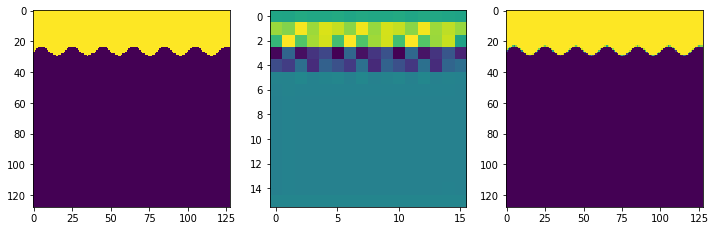

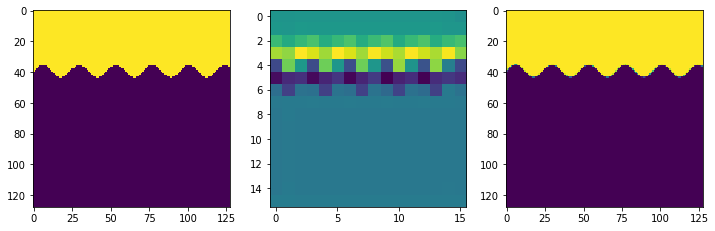

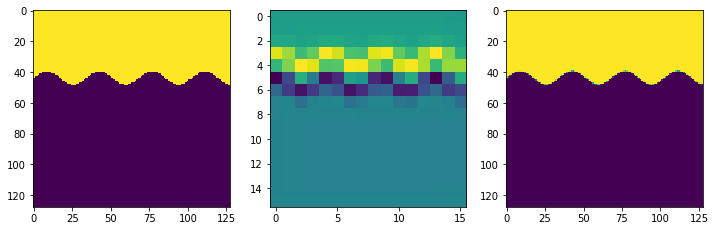

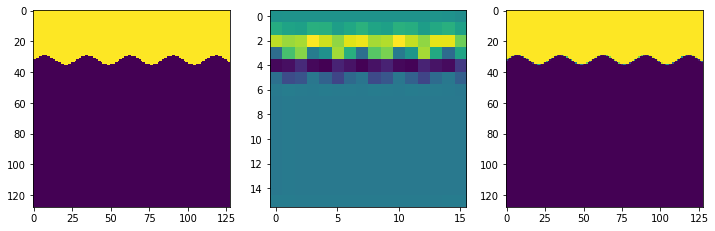

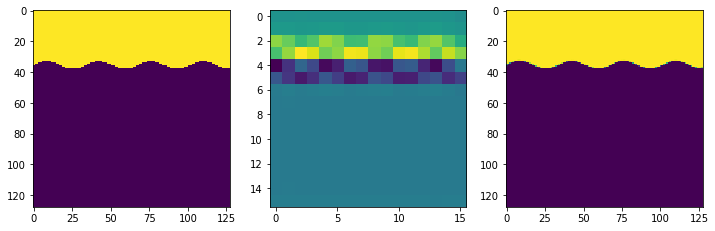

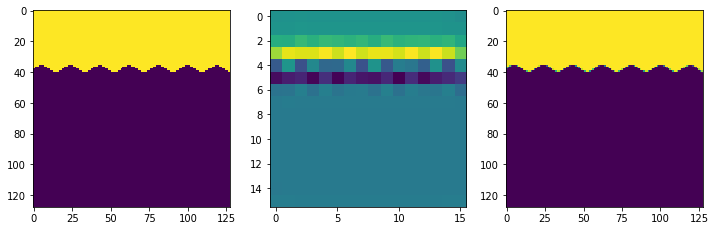

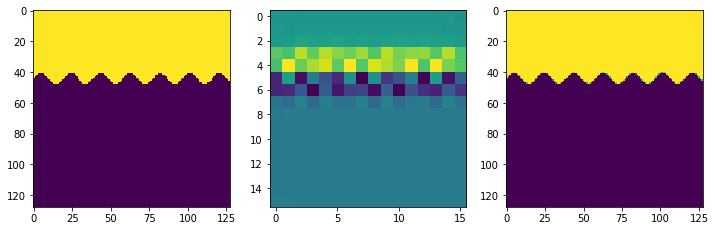

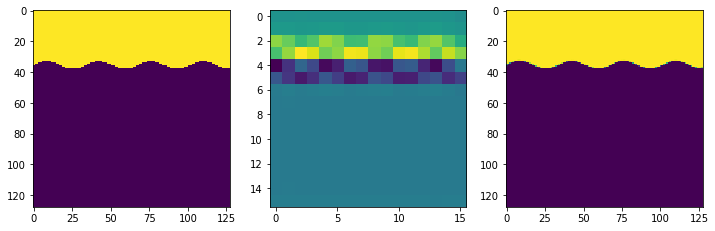

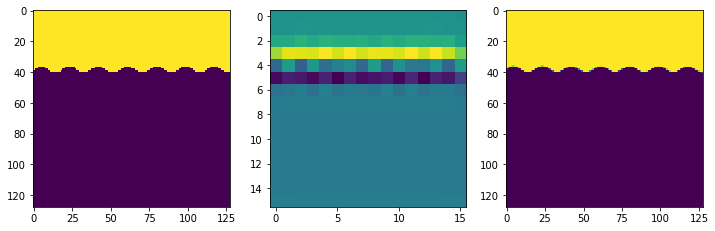

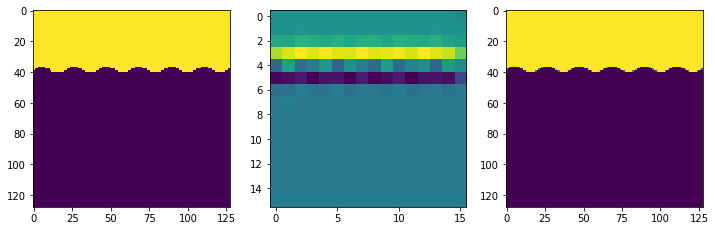

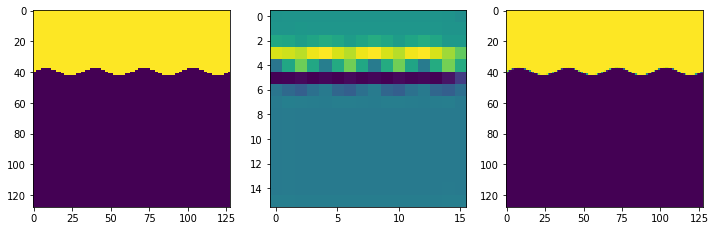

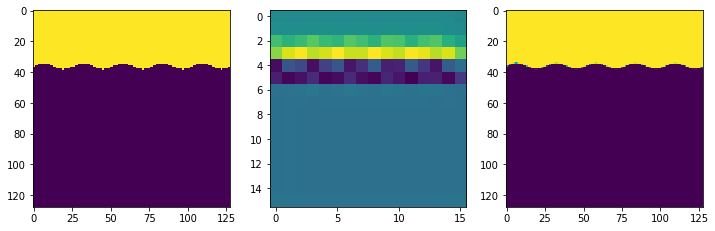

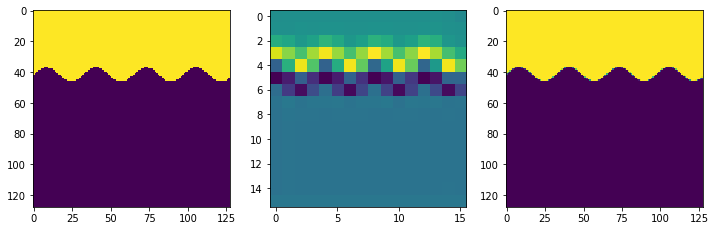

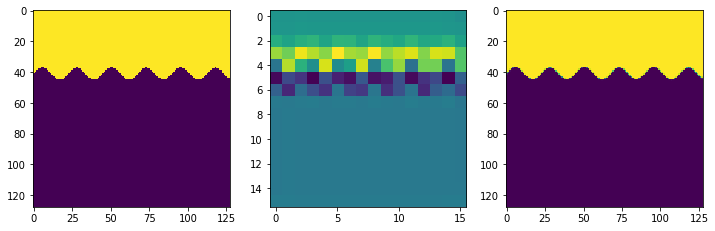

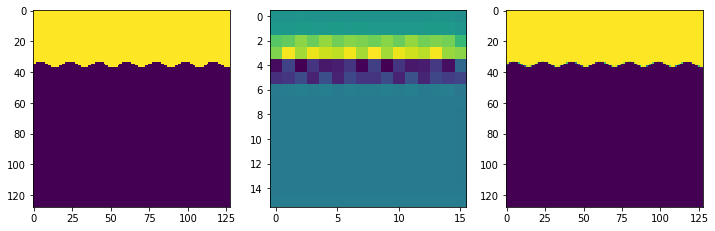

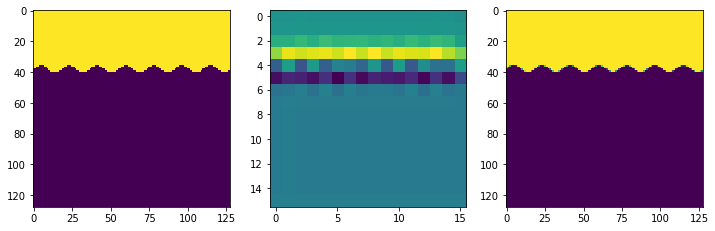

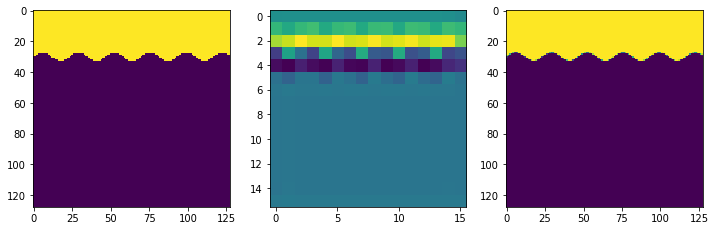

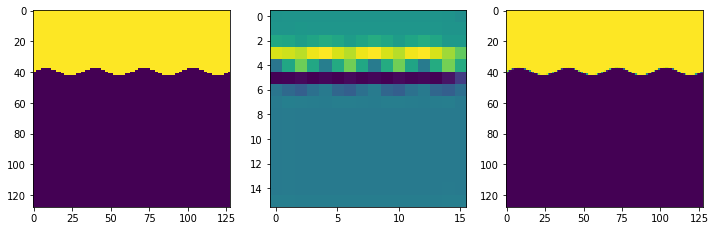

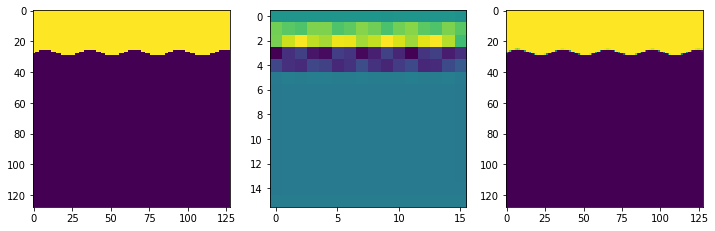

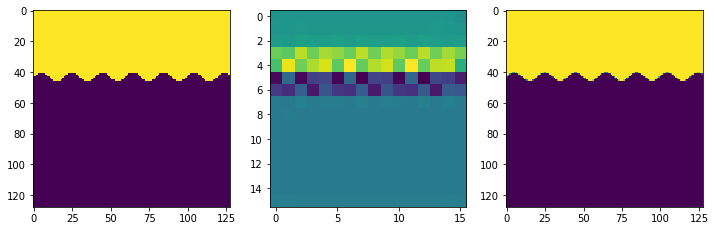

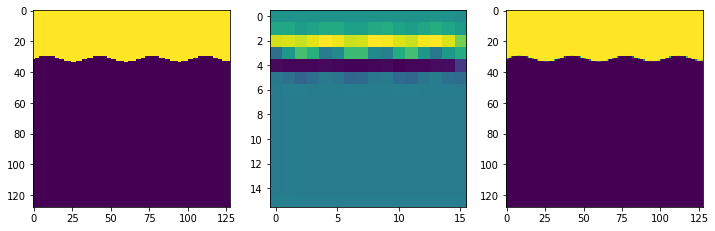

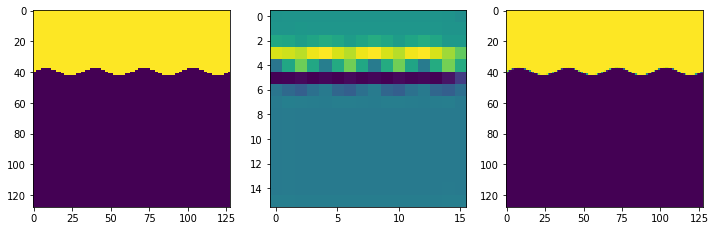

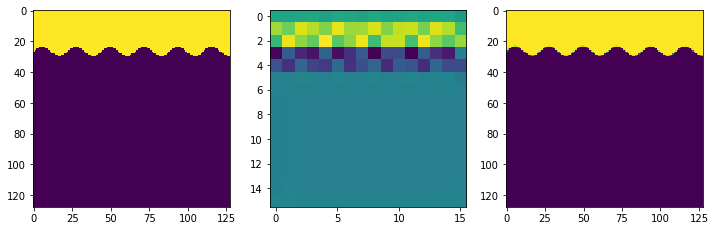

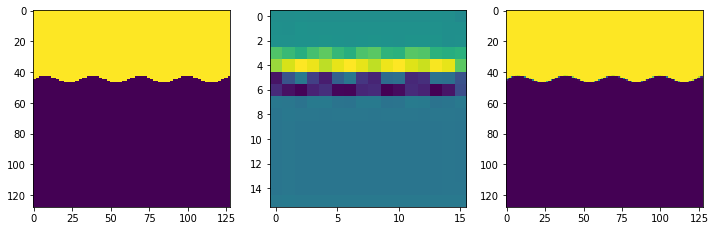

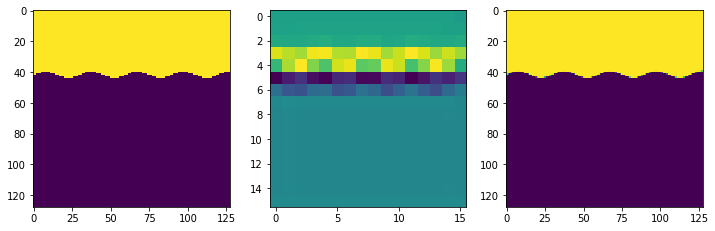

In [0]:
data_batch = next(iter(val_batch_gen))
data = data_batch.to(device)
s = torch.nn.Sigmoid()

hidden = unet.encode(data)
recovered = s(unet.decode(hidden))
for i in np.random.randint(0, BATCH_SIZE, 40):
    f, axarr = plt.subplots(1, 3, figsize=(12, 12))
    axarr[0].imshow(data[i].data.cpu().numpy().reshape(128, 128))
    axarr[1].imshow(hidden[i].data.cpu().numpy().reshape(16, 16))
    axarr[2].imshow(recovered[i].data.cpu().numpy().reshape(128, 128))